In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

# Load datasets
train_data = pd.read_csv('C:/Users/Chitti/Downloads/house-prices-advanced-regression-techniques/train.csv')
test_data = pd.read_csv('C:/Users/Chitti/Downloads/house-prices-advanced-regression-techniques/test.csv')

# Display dataset shapes
print(f"Train Data Shape: {train_data.shape}")
print(f"Test Data Shape: {test_data.shape}")


Train Data Shape: (1460, 81)
Test Data Shape: (1459, 80)


Missing Values in Train Data:
PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64

Missing Values in Test Data:
PoolQC          1456
MiscFeature     1408
Alley           1352
Fence           1169
MasVnrType       894
FireplaceQu      730
LotFrontage      227
GarageYrBlt       78
GarageQual        78
GarageFinish      78
GarageCond        78
GarageType        76
BsmtCond          45
BsmtQual          44
BsmtExposure      44
BsmtFinType1      42
BsmtFinType2      42
MasVnrArea        15
MSZoning           4
BsmtHalfBath       2
Utilities          2
Functional         2
BsmtFullBath       2
BsmtFinSF1         1
BsmtFinSF2         1
Bsm

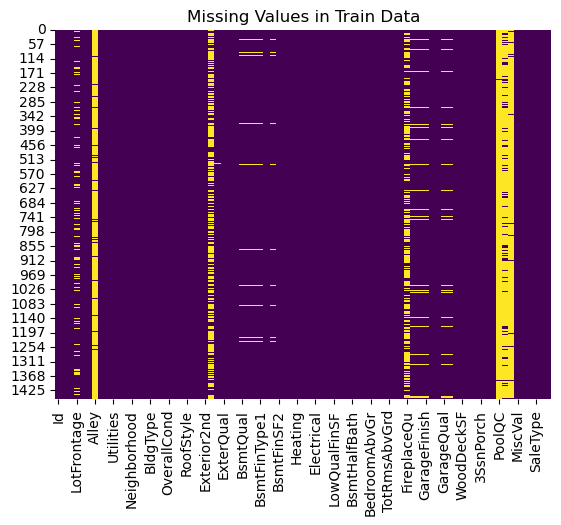

In [2]:
# Check missing values
missing_train = train_data.isnull().sum().sort_values(ascending=False)
missing_test = test_data.isnull().sum().sort_values(ascending=False)

print("Missing Values in Train Data:")
print(missing_train[missing_train > 0])

print("\nMissing Values in Test Data:")
print(missing_test[missing_test > 0])

# Visualize missing data
sns.heatmap(train_data.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values in Train Data")
plt.show()


In [3]:
# Summary statistics
print(train_data.describe())

# Check categorical columns
categorical_cols = train_data.select_dtypes(include=['object']).columns
print(f"Categorical Columns: {categorical_cols.tolist()}")


                Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  ...  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000  ...   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726  ...   
std       1.112799    30.202904     20.645407   181.066207   456.098091  ..

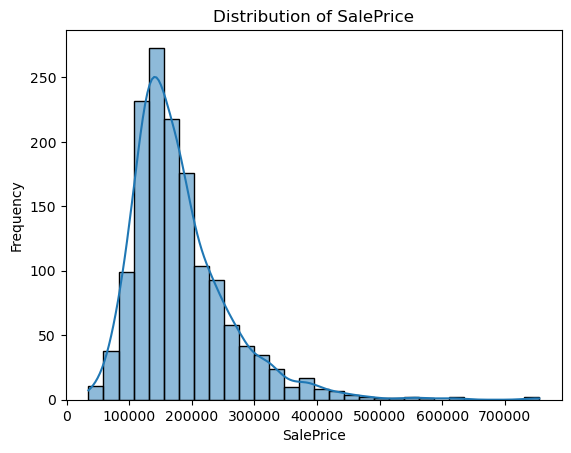

Skewness of SalePrice: 1.880940746034036


In [4]:
# Distribution of SalePrice
sns.histplot(train_data['SalePrice'], kde=True, bins=30)
plt.title("Distribution of SalePrice")
plt.xlabel("SalePrice")
plt.ylabel("Frequency")
plt.show()

# Skewness of SalePrice
from scipy.stats import skew
print(f"Skewness of SalePrice: {skew(train_data['SalePrice'])}")


Top Features Correlated with SalePrice:
SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64


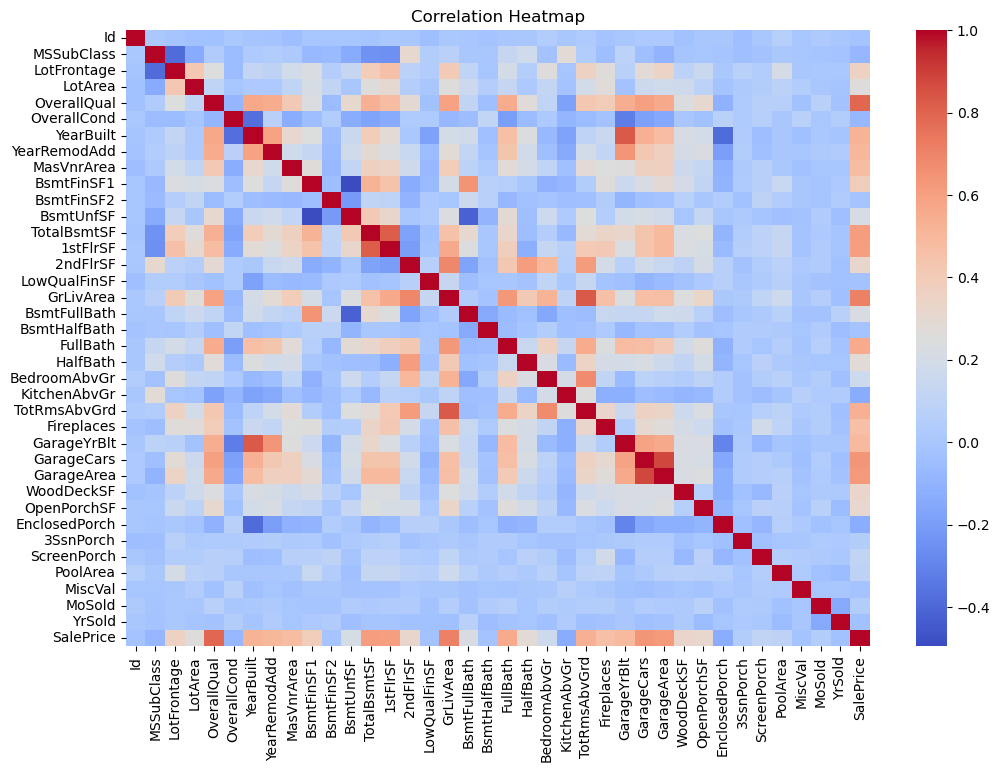

In [6]:
# Select numerical columns only
numerical_train_data = train_data.select_dtypes(include=['float64', 'int64'])

# Correlation matrix for numerical features
corr_matrix = numerical_train_data.corr()

# Correlation with SalePrice
corr_with_target = corr_matrix['SalePrice'].sort_values(ascending=False)
print("Top Features Correlated with SalePrice:")
print(corr_with_target.head(10))

# Heatmap for numerical features
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', cbar=True)
plt.title("Correlation Heatmap")
plt.show()


In [7]:
# Fill missing values
def handle_missing_values(data):
    # Fill numerical missing values with median
    for col in data.select_dtypes(include=['float64', 'int64']).columns:
        data[col] = data[col].fillna(data[col].median())
    
    # Fill categorical missing values with "None"
    for col in data.select_dtypes(include=['object']).columns:
        data[col] = data[col].fillna("None")
    
    return data

train_data_clean = handle_missing_values(train_data)
test_data_clean = handle_missing_values(test_data)


In [8]:
# Engineer new features
train_data_clean['HouseAge'] = train_data_clean['YrSold'] - train_data_clean['YearBuilt']
train_data_clean['RemodelAge'] = train_data_clean['YrSold'] - train_data_clean['YearRemodAdd']

test_data_clean['HouseAge'] = test_data_clean['YrSold'] - test_data_clean['YearBuilt']
test_data_clean['RemodelAge'] = test_data_clean['YrSold'] - test_data_clean['YearRemodAdd']


In [9]:
# Select features common to both datasets
sel_cols = list(set(train_data_clean.columns).intersection(test_data_clean.columns))
X_train = train_data_clean[sel_cols]
X_test = test_data_clean[sel_cols]
y_train = train_data_clean['SalePrice']


In [10]:
# Encode categorical features
def label_encode_combined(train, test):
    combined = pd.concat([train, test], axis=0)
    le = LabelEncoder()
    
    for col in combined.select_dtypes(include=['object']).columns:
        combined[col] = le.fit_transform(combined[col].astype(str))
    
    train_encoded = combined.iloc[:train.shape[0], :]
    test_encoded = combined.iloc[train.shape[0]:, :]
    return train_encoded, test_encoded

X_train_encoded, X_test_encoded = label_encode_combined(X_train, X_test)


In [11]:
# Train-test split
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_encoded, y_train, test_size=0.2, random_state=42
)


In [12]:
# RMSE Function
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Random Forest Parameters
rf_params = [
    {'n_estimators': 50, 'max_depth': 5, 'random_state': 42},
    {'n_estimators': 100, 'max_depth': 10, 'random_state': 42},
    {'n_estimators': 200, 'max_depth': None, 'random_state': 42}
]

# XGBoost Parameters
xgb_params = [
    {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'random_state': 42},
    {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.05, 'random_state': 42},
    {'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.01, 'random_state': 42}
]

# Train and Evaluate Models
rf_results = []
for params in rf_params:
    model = RandomForestRegressor(**params)
    model.fit(X_train_split, y_train_split)
    y_pred = model.predict(X_val_split)
    score = rmse(y_val_split, y_pred)
    rf_results.append((params, score))

xgb_results = []
for params in xgb_params:
    model = XGBRegressor(**params, verbosity=0)
    model.fit(X_train_split, y_train_split)
    y_pred = model.predict(X_val_split)
    score = rmse(y_val_split, y_pred)
    xgb_results.append((params, score))

print("Random Forest Results:", rf_results)
print("XGBoost Results:", xgb_results)


Random Forest Results: [({'n_estimators': 50, 'max_depth': 5, 'random_state': 42}, 32559.570035554094), ({'n_estimators': 100, 'max_depth': 10, 'random_state': 42}, 29523.397261190417), ({'n_estimators': 200, 'max_depth': None, 'random_state': 42}, 28526.486073552045)]
XGBoost Results: [({'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'random_state': 42}, 28492.87645584666), ({'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.05, 'random_state': 42}, 25881.266284713012), ({'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.01, 'random_state': 42}, 32877.19174726547)]


In [13]:
# Fit the best XGBoost model
best_xgb_model = XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.05, random_state=42, verbosity=0)
best_xgb_model.fit(X_train_encoded, y_train)

# Predict on the test set
test_predictions = best_xgb_model.predict(X_test_encoded)

# Create the submission file
submission = pd.DataFrame({
    'Id': test_data['Id'],
    'SalePrice': test_predictions
})

# Save the submission
submission.to_csv('house_price_predictions.csv', index=False)
print("Submission file created: house_price_predictions.csv")


Submission file created: house_price_predictions.csv


In [15]:
print(submission)


        Id      SalePrice
0     1461  126784.742188
1     1462  152023.140625
2     1463  182998.375000
3     1464  185007.062500
4     1465  203078.562500
...    ...            ...
1454  2915   82623.382812
1455  2916   84287.320312
1456  2917  161207.281250
1457  2918  114822.921875
1458  2919  219070.390625

[1459 rows x 2 columns]
